In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
import pickle
with open('moge/data/luad_data_multi_seq.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network.process_genes_info()

Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: -50
Total nodes (filtered): 32530


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

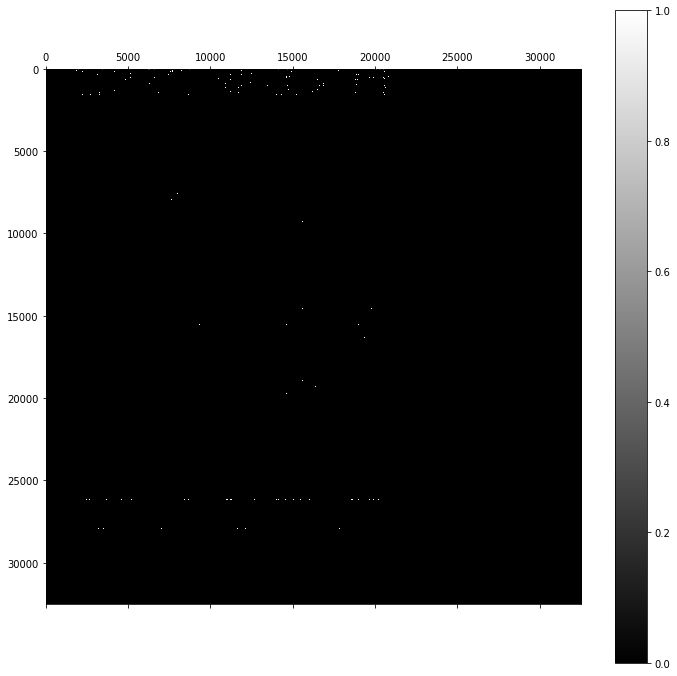

In [23]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

In [ ]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["GE"]).todense())

In [ ]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [4]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=128, batch_size=2048, lr=0.001, epochs=20, negative_sampling_ratio=2.0,
                                 max_length=1400, truncating="random", verbose=True)

Using TensorFlow backend.


In [5]:
# starbase_test_edges = [(u,v,d) for u,v,d in network_val.G.edges(data=True) if "database" in d and d["database"] in "starBase"]
# network_val.G.remove_edges_from(starbase_test_edges)
# starbase_train_edges = [(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"] in "starBase"]
# network.G.remove_edges_from(starbase_train_edges)

In [5]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, 
                        subsample=False, directed_proba=0.5, n_steps=2000, validation_steps=None, compression_func="log",
                        seed=2)

Ed_count: 376094 , Eu_count: 347505 , En_count: 1612996
Ens_count: 752188
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5} defaultdict(<class 'int'>, {5: 1604, 3: 32530, 1: 32494, 4: 32499, 2: 30916})
Ed_count: 1161527 , Eu_count: 0 , En_count: 0
Ens_count: 2323054
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5} defaultdict(<class 'int'>, {5: 1604, 3: 32577, 1: 32541, 4: 32546, 2: 30963})
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/d

# Visualize Embeddings

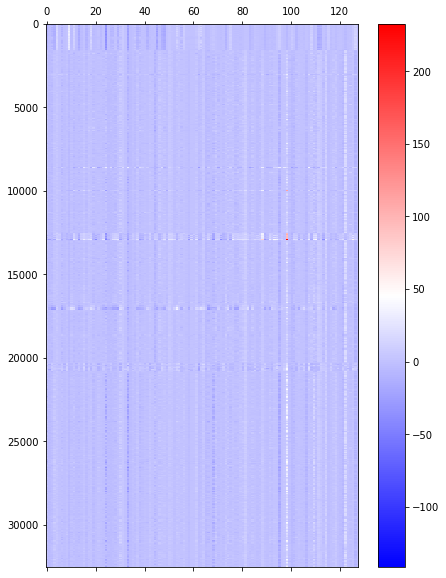

In [6]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

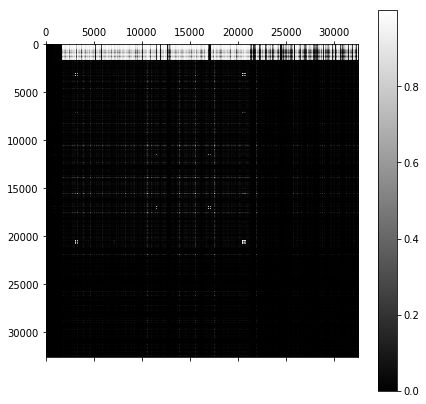

In [11]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list), figsize=(7,7))

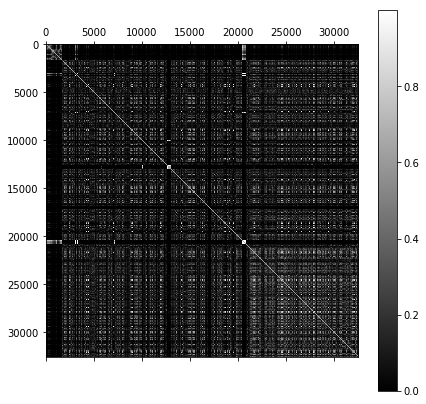

In [10]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u"), figsize=(7,7))

# Plot measures on training and testing

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])


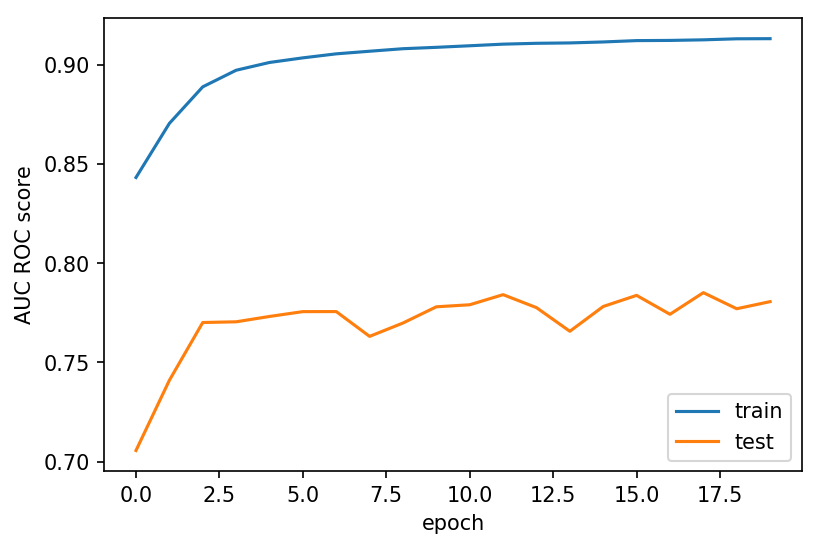

In [12]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=150)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model & Embedding

In [36]:
siamese.lstm_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")
siamese.alpha_network.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_128.randtrunc.multi_seq.no_starbase.sampled.l1_bce.e20.weights.h5")

In [37]:
siamese.siamese_net.save_weights("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/Models/siamese_128.randtrunc.multi.full.l1_bce.e20.weights")

In [29]:
alpha_directed = siamese.alpha_network.layers[5]
alpha_undirected = siamese.alpha_network.layers[6]

In [31]:
alpha_directed.get_weights()

[array([[-4.78622271e-04],
        [-6.59492565e-04],
        [-7.99483096e-04],
        [ 2.40140478e-04],
        [ 1.11826230e-05],
        [-1.64823083e-04],
        [-8.76913429e-04],
        [-5.73298079e-04],
        [-4.24118363e-04],
        [-8.80826614e-04],
        [-1.19347125e-04],
        [-3.14652687e-04],
        [-6.76636817e-04],
        [-4.67567472e-04],
        [-6.81880221e-04],
        [-5.09352190e-04],
        [-1.16350059e-03],
        [-5.08309342e-03],
        [-6.15257188e-04],
        [-1.45943800e-03],
        [ 4.87317448e-05],
        [-1.06218439e-02],
        [-3.92265152e-04],
        [-7.41318159e-04],
        [-7.49097671e-04],
        [-9.58008284e-04],
        [-1.51935150e-04],
        [-2.25349999e-04],
        [-5.74205187e-04],
        [ 1.74580161e-02],
        [-7.38994451e-04],
        [-5.74328995e-04],
        [-1.27519015e-05],
        [-1.08769722e-03],
        [-1.88667444e-04],
        [-2.73072917e-04],
        [ 1.10291512e-04],
 

In [33]:
with open("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/alpha_undirected_weights.pickle", mode="wb") as file:
    pickle.dump(alpha_undirected.get_weights(), file)

In [ ]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_edges20_train.siamese.multi_seq.directed80.l1_bce.trunc.emb", 
                        variable_length=False, recompute=True, minlen=100)

In [ ]:
lstm_network.summary()

# Import different models

In [13]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/Embeddings/lmn_edges20_train.siamese.multi_seq.no_starbase.sampled.l1_bce.trunc.emb", 
                         node_list=network.node_list)
print()

node2vec imported (20507, 128)
LINE imported (20507, 128)
HOPE imported (20507, 128)
SDNE imported (20507, 128)
rna2rna imported (32533, 128)



In [14]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
methods["siamese"] = siamese

# Prepare True label

In [16]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=siamese.batch_size,
                             maxlen=1400,
                             truncating="post",
                             shuffle=True, seed=0)
generator_Ed.on_epoch_end()


Ed_count: 1161527 , Eu_count: 0 , En_count: 0
Ens_count: 2323054
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5} defaultdict(<class 'int'>, {5: 1604, 3: 32577, 1: 32541, 4: 32546, 2: 30963})


In [17]:
X, y_true = generator_Ed.make_dataset()
y_true.shape
# y_true = y_true.astype(int)
# y_true = (y_true > 0).astype(int)

(3483648, 1)

In [21]:
y_pred_dict = {}
y_pred_dict["LINE"] = line_emb.predict(X)
y_pred_dict["HOPE"] = hope_emb.predict(X)
y_pred_dict["SDNE"] = sdne_emb.predict(X)
y_pred_dict["node2vec"] = node2vec_emb.predict(X)
y_pred_dict["rna2rna"] = rna2rna_emb.predict(X)
y_pred_dict["siamese"] = siamese.predict_generator(generator_Ed)

InvalidArgumentError: Expected size[0] in [0, 1], but got 512
	 [[{{node replica_0/lambda_7/Slice}} = Slice[Index=DT_INT32, T=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_is_directed_0_2, replica_0/lambda_7/mul_1, replica_0/lambda_7/concat)]]

# Plot Precision-Recall Curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score ,precision_recall_curve

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_dict = {"LINE":"b", "HOPE":"b", "SDNE":"y", "node2vec":"g", "rna2rna":"r", "siamese":"r"}
ls_dict = {"LINE":":", "HOPE":"-", "SDNE":"--", "node2vec":"--", "rna2rna":"-", "siamese":":"}

for method in y_pred_dict.keys():
    y_prob_pred = y_pred_dict[method]
    average_precision = average_precision_score(y_true=y_true, y_score=y_prob_pred)
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

    ax.plot(recall, precision, color=color_dict[method], ls=ls_dict[method],
             label=method+'. AUPR={0:0.2f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('starBase mRNA-RNA 50%-test PR curve')
plt.show()

Method: node2vec
Method: LINE
Method: HOPE
Method: SDNE
Method: rna2rna
Method: siamese


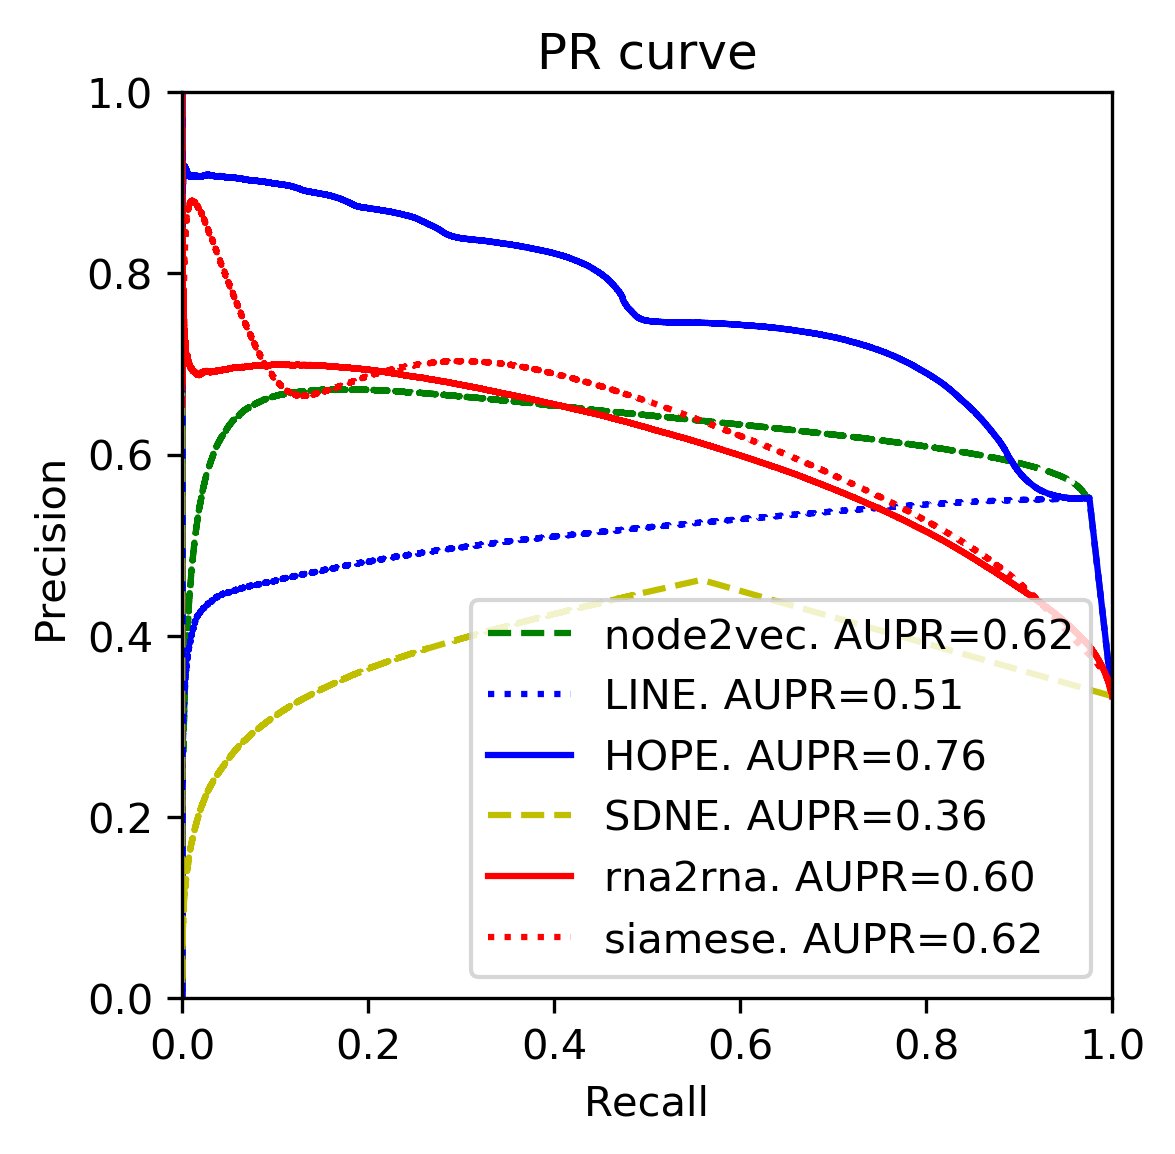

In [18]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred
evaluate_pr_curve_link_pred(methods, X, y_true)

# Top-K Link Prediction

In [19]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

node2vec
{'precision': 0.0016, 'recall': 1.412102779900835e-05}
LINE
{'precision': 0.0005, 'recall': 4.41282118719011e-06}
HOPE
{'precision': 0.0209, 'recall': 0.00018445592562454658}
SDNE
{'precision': 0.0002, 'recall': 1.7651284748760438e-06}
rna2rna
{'precision': 0.0083, 'recall': 7.145753571370151e-05}
siamese
{'precision': 0.0038, 'recall': 3.2715498278562136e-05}


In [20]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

node2vec
Clustering 12896 nodes with n_clusters: 500
{'homogeneity': 0.47933710323677775, 'completeness': 0.5313813752135991, 'nmi': 0.5040192982310601}
LINE
Clustering 12896 nodes with n_clusters: 500
{'homogeneity': 0.49561460337349966, 'completeness': 0.5378608577770158, 'nmi': 0.5158742625597038}
HOPE
Clustering 12896 nodes with n_clusters: 500
{'homogeneity': 0.3959111759420701, 'completeness': 0.5009439586096915, 'nmi': 0.44227725101526344}
SDNE
Clustering 12896 nodes with n_clusters: 500
{'homogeneity': 0.3590255129761642, 'completeness': 0.4791483176664181, 'nmi': 0.41047922102260936}
rna2rna
Clustering 14312 nodes with n_clusters: 500
{'homogeneity': 0.44157849682680467, 'completeness': 0.5001441817801846, 'nmi': 0.46904024083577367}
siamese
Clustering 14312 nodes with n_clusters: 500
{'homogeneity': 0.4821442893178701, 'completeness': 0.5409445776172699, 'nmi': 0.5098547103086962}


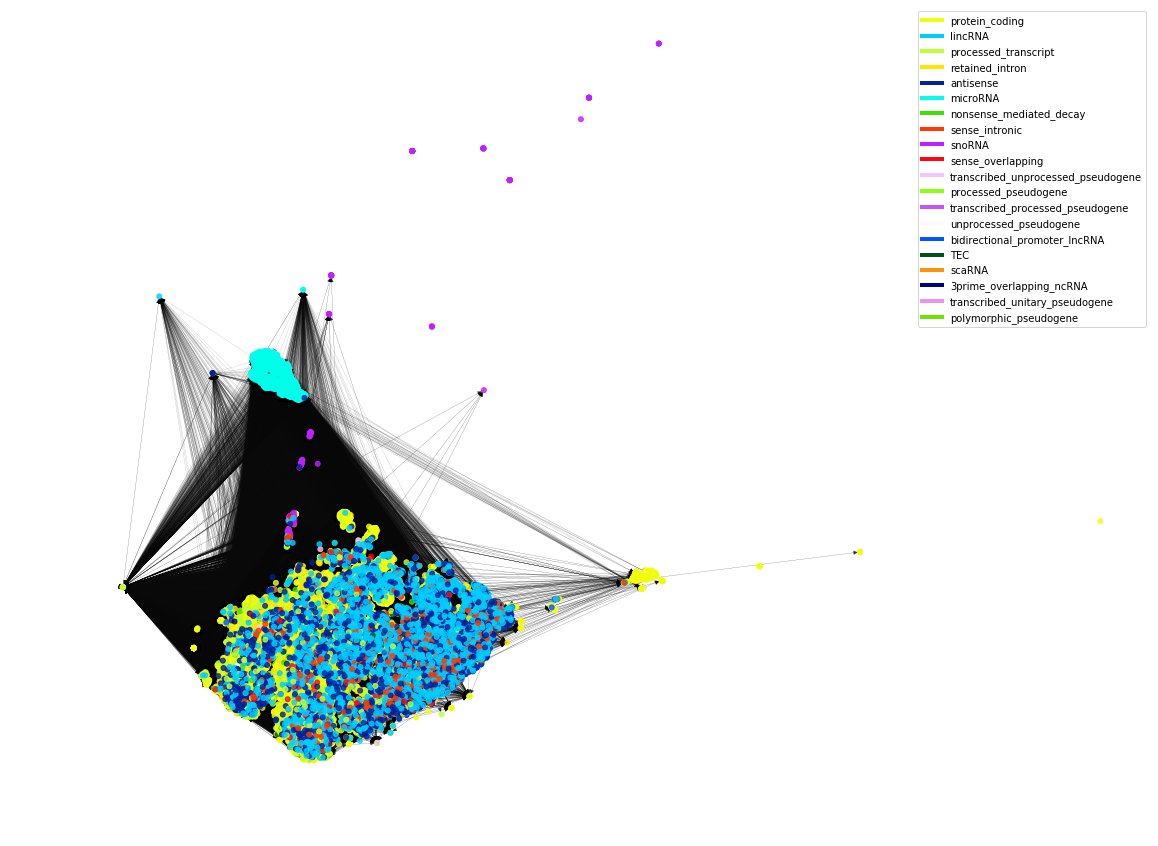

In [21]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network_val.node_list, edge_types=["d"]),
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

In [22]:
from moge.evaluation.node_classification import evaluate_classification

for method in methods.keys():
    print()
    print(method)
    print([(k, np.average(v)) for k,v in evaluate_classification(methods[method], network, cv=5,
                                  node_label="Family", multilabel=False,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()])


node2vec
# of labels with >cv samples: 567 , # of nodes to train/test: 10235


/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


OSError: [Errno 12] Cannot allocate memory

In [ ]:
for method in methods.keys():
    print("\n", method)
    for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
        print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))

In [ ]:
for method in ["siamese"]:
    print("\n", method)
    for A, B in [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]:
        print(A, B, methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B]))

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>